In [28]:
import pickle
import pycaret
import pandas as pd
import seaborn as sns
from pycaret.classification import *
from dataprep.eda import create_report
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_relevant_features
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters

In [29]:
cmap='seismic'
sns.set_palette(sns.color_palette(cmap))

In [30]:
metric = 'AUC' # F1 or AUC

-----------------------------
# Functions

In [31]:
def train_test_split_per_user(data, train_size=0.7):
    users = list(set(data.id))
    users = sorted(users, reverse=True)  # fix randomness
    total_users = len(users)
    slice = int(train_size * total_users)
    users_train = users[:slice]
    users_test = users[slice:]
    return data[data.id.isin(users_train)], data[data.id.isin(users_test)]

-----------
# Reading the data

In [32]:
df=pd.read_pickle('../data/unified_dataframe/data_unprocessed.pkl')
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,label_ttm_stage,label_breq_self_determination,label_sema_negative_feelings,label_ipip_extraversion_category,label_ipip_agreeableness_category,label_ipip_conscientiousness_category,label_ipip_stability_category,label_ipip_intellect_category,label_stai_stress_category,label_panas_negative_affect
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,...,Maintenance,intrinsic_regulation,NaN,LOW,LOW,HIGH,HIGH,AVERAGE,NaN,NaN
1,621e328667b776a240281372,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Maintenance,intrinsic_regulation,NaN,HIGH,AVERAGE,HIGH,LOW,LOW,NaN,NaN
2,621e326767b776a24012e179,2021-05-24,NaN,46.120,53.968,95.3,14.4,80.0,0.666667,0.925,...,Maintenance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,621e332267b776a24092a584,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Maintenance,identified_regulation,NaN,LOW,LOW,LOW,AVERAGE,HIGH,NaN,NaN
4,621e333567b776a240a0c217,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Contemplation,intrinsic_regulation,NaN,AVERAGE,HIGH,AVERAGE,LOW,LOW,NaN,NaN


In [33]:
#create_report(df).show_browser()

In [34]:
df_pre=pd.read_pickle('../data/unified_dataframe/data_preprocessed.pkl')
df_pre.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,Steps_hour14,Steps_hour15,Steps_hour16,Steps_hour17,Steps_hour18,Steps_hour19,Steps_hour20,Steps_hour21,Steps_hour22,Steps_hour23
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,95.9,14.8,78.0,0.833333,0.675,...,191.0,33.0,342.0,1712.0,1838.0,160.0,155.0,37.0,31.0,53.0
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,95.9,15.8,80.0,0.833333,0.725,...,120.0,24.0,446.0,377.0,3165.0,332.0,97.0,9.0,24.0,58.0
2,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,95.9,15.8,80.0,0.833333,0.725,...,120.0,24.0,446.0,377.0,3165.0,332.0,97.0,9.0,24.0,58.0
3,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,35.216,95.9,14.6,84.0,0.966667,0.725,...,85.0,477.0,390.0,2821.0,293.0,158.0,66.0,0.0,70.0,74.0
4,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,35.216,95.9,14.8,82.0,0.933333,0.725,...,58.0,296.0,401.0,21.0,3054.0,503.0,411.0,96.0,63.0,8.0


In [35]:
#create_report(df_pre).show_browser()

-----------------
# Predicting semas negative feelings

In [36]:
df.columns

Index(['id', 'date', 'nightly_temperature', 'nremhr', 'rmssd', 'spo2',
       'full_sleep_breathing_rate', 'stress_score', 'sleep_points_percentage',
       'exertion_points_percentage', 'responsiveness_points_percentage',
       'daily_temperature_variation', 'badgeType', 'calories',
       'filteredDemographicVO2Max', 'distance', 'activityType', 'bpm',
       'lightly_active_minutes', 'moderately_active_minutes',
       'very_active_minutes', 'sedentary_minutes', 'mindfulness_session',
       'scl_avg', 'resting_hr', 'sleep_duration', 'minutesToFallAsleep',
       'minutesAsleep', 'minutesAwake', 'minutesAfterWakeup',
       'sleep_efficiency', 'sleep_deep_ratio', 'sleep_wake_ratio',
       'sleep_light_ratio', 'sleep_rem_ratio', 'steps',
       'minutes_in_default_zone_1', 'minutes_below_default_zone_1',
       'minutes_in_default_zone_2', 'minutes_in_default_zone_3', 'age',
       'gender', 'bmi', 'heart_rate_alert', 'startTime', 'endTime',
       'label_ttm_stage', 'label_breq_sel

In [37]:
sema = df.drop(columns=['date','startTime', 'endTime', 'label_ttm_stage', 
                        'label_breq_self_determination','label_ipip_extraversion_category',
                        'label_ipip_agreeableness_category',
                        'label_ipip_conscientiousness_category',
                        'label_ipip_stability_category', 'label_ipip_intellect_category',
                        'label_stai_stress_category', 'label_panas_negative_affect'])

In [38]:
train_data, test_data = train_test_split_per_user(sema)

fold_groups = train_data.id
train_data = train_data.drop(columns=['id'])
test_data = test_data.drop(columns=['id'])

In [39]:
s = setup(data=train_data, target='label_sema_negative_feelings', silent=True, session_id=123, 
          fold_strategy='groupkfold', fold=3,  fold_groups=fold_groups, test_data=test_data)

,Description,Value
0,session_id,123
1,Target,label_sema_negative_feelings
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(5199, 43)"
5,Missing Values,True
6,Numeric Features,33
7,Categorical Features,9
8,Ordinal Features,False
9,High Cardinality Features,False


create_model_container: 0
master_model_container: 0
display_container: 1
Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='label_sema_negative_feelings',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numer...
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_all', 'passthrough'),
                ('dummy', Dummify(target='label_sema_negative_feelings')),
            

**compare_models:** 
This function trains and evaluates the performance of all estimators available in the model library using cross-validation. The output of this function is a scoring grid with average cross-validated scores.

In [40]:
best = compare_models(sort = '%s'%metric) # change to F1 and AUC

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5084,0.5266,0.5546,0.4666,0.5039,0.0260,0.0268,0.0567
lr,Logistic Regression,0.5456,0.5204,0.0106,0.1667,0.0199,0.0023,0.0061,0.0567
gbc,Gradient Boosting Classifier,0.5459,0.5164,0.3278,0.5017,0.3808,0.0603,0.0645,0.4300
knn,K Neighbors Classifier,0.5140,0.5155,0.4433,0.4629,0.4509,0.0181,0.0179,0.0967
lightgbm,Light Gradient Boosting Machine,0.5282,0.5099,0.3588,0.4741,0.4022,0.0298,0.0305,0.3167
rf,Random Forest Classifier,0.5185,0.5034,0.3982,0.4678,0.4236,0.0224,0.0231,0.1933
dummy,Dummy Classifier,0.5456,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0500
dt,Decision Tree Classifier,0.5061,0.4997,0.3482,0.4426,0.3889,-0.0150,-0.0159,0.0767
qda,Quadratic Discriminant Analysis,0.4880,0.4983,0.6091,0.3024,0.4033,-0.0116,-0.0180,0.0633
ada,Ada Boost Classifier,0.5105,0.4950,0.3051,0.4424,0.3523,-0.0110,-0.0127,0.1633


create_model_container: 14
master_model_container: 14
display_container: 2
GaussianNB(priors=None, var_smoothing=1e-09)
compare_models() succesfully completed......................................


In [41]:
print(df_pre.columns.tolist())

['id', 'date', 'nightly_temperature', 'nremhr', 'rmssd', 'spo2', 'full_sleep_breathing_rate', 'stress_score', 'sleep_points_percentage', 'exertion_points_percentage', 'responsiveness_points_percentage', 'daily_temperature_variation', 'calories', 'filteredDemographicVO2Max', 'distance', 'bpm', 'lightly_active_minutes', 'moderately_active_minutes', 'very_active_minutes', 'sedentary_minutes', 'mindfulness_session', 'scl_avg', 'resting_hr', 'sleep_duration', 'minutesToFallAsleep', 'minutesAsleep', 'minutesAwake', 'minutesAfterWakeup', 'sleep_efficiency', 'sleep_deep_ratio', 'sleep_wake_ratio', 'sleep_light_ratio', 'sleep_rem_ratio', 'steps', 'minutes_in_default_zone_1', 'minutes_below_default_zone_1', 'minutes_in_default_zone_2', 'minutes_in_default_zone_3', 'age', 'gender', 'bmi', 'label_ttm_stage', 'label_breq_self_determination', 'label_sema_negative_feelings', 'label_ipip_extraversion_category', 'label_ipip_agreeableness_category', 'label_ipip_conscientiousness_category', 'label_ipip_s

In [42]:
sema = df_pre.drop(columns=['date', 'label_ttm_stage', 
                        'label_breq_self_determination','label_ipip_extraversion_category',
                        'label_ipip_agreeableness_category',
                        'label_ipip_conscientiousness_category',
                        'label_ipip_stability_category', 'label_ipip_intellect_category',
                        'label_stai_stress_category', 'label_panas_negative_affect'])

In [43]:
print(sema['label_sema_negative_feelings'].isna().sum())
sema = sema[sema['label_sema_negative_feelings'].notna()]
print(sema['label_sema_negative_feelings'].isna().sum())

2711
0


In [44]:
train_data, test_data = train_test_split_per_user(sema)

fold_groups = train_data.id
train_data = train_data.drop(columns=['id'])
test_data = test_data.drop(columns=['id'])

https://pycaret.gitbook.io/docs/get-started/preprocessing/scale-and-transform#effect-of-feature-transformation

In [45]:
s = setup(data=train_data, target='label_sema_negative_feelings', silent=True, session_id=123, 
          fold_strategy='groupkfold', fold=3,  fold_groups=fold_groups, test_data=test_data, 
          normalize=True, normalize_method='minmax', fix_imbalance=True, remove_multicollinearity = True,
          multicollinearity_threshold = 0.6)

,Description,Value
0,session_id,123
1,Target,label_sema_negative_feelings
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(3323, 148)"
5,Missing Values,True
6,Numeric Features,109
7,Categorical Features,38
8,Ordinal Features,False
9,High Cardinality Features,False


create_model_container: 0
master_model_container: 0
display_container: 1
Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='label_sema_negative_feelings',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numer...
                 Remove_100(target='label_sema_negative_feelings')),
                ('clean_names', Clean_Colum_Names()),
                ('feature_select', 'passthrough'),
                ('fix_multi',
     

In [46]:
best = compare_models(sort = '%s'%metric) # change to F1 and AUC

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.5266,0.5298,0.3997,0.4753,0.4254,0.0307,0.0324,0.3367
ada,Ada Boost Classifier,0.5188,0.5255,0.4365,0.4644,0.4475,0.0262,0.0261,0.3200
lightgbm,Light Gradient Boosting Machine,0.5266,0.5229,0.4068,0.4716,0.4362,0.0302,0.0307,0.2767
gbc,Gradient Boosting Classifier,0.5176,0.5225,0.3880,0.4596,0.4194,0.0128,0.0132,0.9767
rf,Random Forest Classifier,0.5158,0.5203,0.3958,0.4557,0.4201,0.0081,0.0083,0.2867
nb,Naive Bayes,0.4577,0.5202,0.6893,0.4362,0.4994,-0.0105,-0.0014,0.1233
qda,Quadratic Discriminant Analysis,0.4818,0.5160,0.9095,0.4592,0.6099,0.0287,0.0594,0.1267
lr,Logistic Regression,0.5131,0.5151,0.4156,0.4564,0.4336,0.0108,0.0108,0.1600
dt,Decision Tree Classifier,0.5227,0.5132,0.4536,0.4719,0.4596,0.0361,0.0370,0.1400
dummy,Dummy Classifier,0.5498,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1367


create_model_container: 14
master_model_container: 14
display_container: 2
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)
compare_models() succesfully completed......................................


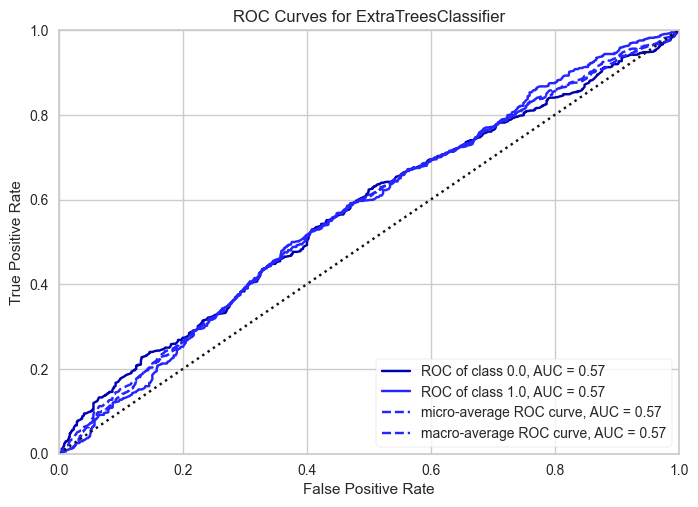

Visual Rendered Successfully
plot_model() succesfully completed......................................


In [47]:
plot_model(best, plot = 'auc')

In [48]:
df=pd.read_pickle('../data/unified_dataframe/data_preprocessed.pkl')

sema = df.drop(columns=['date', 'label_ttm_stage', 
                        'label_breq_self_determination','label_ipip_extraversion_category',
                        'label_ipip_agreeableness_category',
                        'label_ipip_conscientiousness_category',
                        'label_ipip_stability_category', 'label_ipip_intellect_category',
                        'label_stai_stress_category', 'label_panas_negative_affect'])

sema = sema[sema['label_sema_negative_feelings'].notna()]
y = sema['label_sema_negative_feelings']

In [49]:
cols = ['stress_score', 'steps', 'sleep_duration']

for col in cols:
    extracted_features = extract_features(df, column_id="id", column_sort="date", 
                                          n_jobs=5, column_kind=None, column_value=col, 
                                          show_warnings=False)
    extracted_features = extracted_features.reset_index()
    extracted_features = extracted_features.rename(columns={"index": "id"})
    sema = sema.merge(extracted_features, how='left', on=['id'])

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.73it/s]


In [50]:
train_data, test_data = train_test_split_per_user(sema)

fold_groups = train_data.id
train_data = train_data.drop(columns=['id'])
test_data = test_data.drop(columns=['id'])

In [51]:
s = setup(data=train_data, target='label_sema_negative_feelings', silent=True, session_id=123, 
          fold_strategy='groupkfold', fold=3,  fold_groups=fold_groups, test_data=test_data, 
          normalize=True, normalize_method='minmax', fix_imbalance=True, remove_multicollinearity = True,
          multicollinearity_threshold = 0.6)

,Description,Value
0,session_id,123
1,Target,label_sema_negative_feelings
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(3323, 2515)"
5,Missing Values,True
6,Numeric Features,2242
7,Categorical Features,272
8,Ordinal Features,False
9,High Cardinality Features,False


create_model_container: 0
master_model_container: 0
display_container: 1
Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[],
                                      target='label_sema_negative_feelings',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numer...
                 Remove_100(target='label_sema_negative_feelings')),
                ('clean_names', Clean_Colum_Names()),
                ('feature_select', 'passthrough'),
                ('fix_multi',
     

In [52]:
best = compare_models(sort = '%s'%metric) # change to F1 and AUC

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5805,0.6017,0.5299,0.5514,0.5267,0.1388,0.1442,0.5800
lda,Linear Discriminant Analysis,0.5627,0.5870,0.5174,0.5213,0.5165,0.1106,0.1116,0.4800
et,Extra Trees Classifier,0.5579,0.5782,0.5133,0.5032,0.5056,0.0968,0.0977,0.6067
nb,Naive Bayes,0.4761,0.5542,0.9288,0.4594,0.6141,0.0314,0.0600,0.3967
knn,K Neighbors Classifier,0.5444,0.5532,0.5152,0.4938,0.5038,0.0824,0.0825,1.3333
gbc,Gradient Boosting Classifier,0.5369,0.5426,0.4756,0.4848,0.4795,0.0565,0.0566,1.8400
lightgbm,Light Gradient Boosting Machine,0.5381,0.5399,0.4626,0.4863,0.4732,0.0609,0.0612,0.8767
ada,Ada Boost Classifier,0.5236,0.5248,0.5456,0.4734,0.5060,0.0415,0.0416,0.8433
rf,Random Forest Classifier,0.5287,0.5187,0.4165,0.4753,0.4394,0.0269,0.0285,0.6567
dt,Decision Tree Classifier,0.5212,0.5132,0.4437,0.4645,0.4532,0.0210,0.0211,0.3800


create_model_container: 14
master_model_container: 14
display_container: 2
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
compare_models() succesfully completed......................................


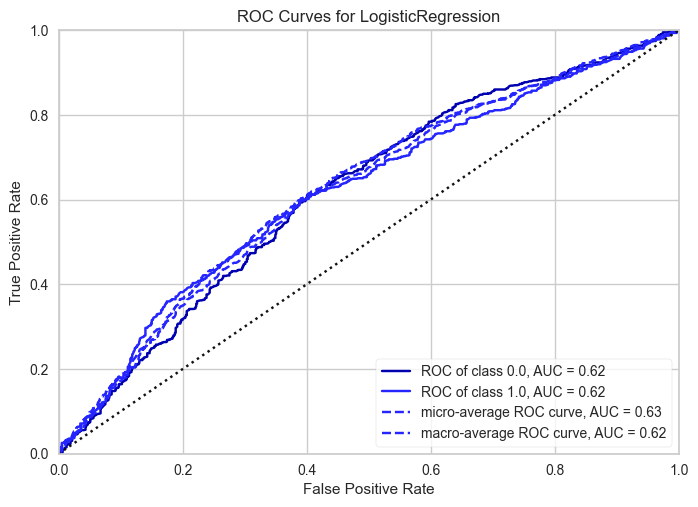

Visual Rendered Successfully
plot_model() succesfully completed......................................


In [53]:
plot_model(best, plot = 'auc')

In [54]:
d=pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(best.coef_[0])}).sort_values(by='Value', ascending=False)

Initializing get_config()
get_config(variable=X_train)
Global variable: X_train returned as       nightly_temperature    nremhr     rmssd  spo2  \
1770             0.580543  0.476606  0.346682  0.55   
1771             0.580543  0.476606  0.346682  0.55   
1772             0.580543  0.476606  0.346682  0.55   
1773             0.580543  0.476606  0.346682  0.55   
1774             0.655457  0.476606  0.346682  0.55   
...                   ...       ...       ...   ...   
5088             0.698849  0.587568  0.185105  0.55   
5089             0.714042  0.689428  0.162325  0.55   
5090             0.756420  0.561605  0.178647  0.55   
5091             0.756420  0.561605  0.178647  0.55   
5092             0.895148  0.547071  0.185942  0.55   

      full_sleep_breathing_rate  sleep_points_percentage  \
1770                   0.347826                 0.533333   
1771                   0.347826                 0.533333   
1772                   0.347826                 0.533333   
1773   

In [55]:
pd.set_option('display.max_rows', 500)
d.reset_index(inplace=True)
d

,index,Feature,Value
0,13,minutesAsleep,1.566284
1,37,endHour_cos,1.192542
2,8,filteredDemographicVO2Max,1.121773
3,375,Elliptical_1.0,1.018914
4,42,Steps_hour4,0.992801
5,12,minutesToFallAsleep,0.866954
6,378,Martial Arts_1.0,0.772400
7,41,Steps_hour3,0.751493
8,16,sleep_deep_ratio,0.637419
9,381,Swim_1.0,0.635738


In [56]:
d['Feature']

0                                          minutesAsleep
1                                            endHour_cos
2                              filteredDemographicVO2Max
3                                         Elliptical_1.0
4                                            Steps_hour4
5                                    minutesToFallAsleep
6                                       Martial Arts_1.0
7                                            Steps_hour3
8                                       sleep_deep_ratio
9                                               Swim_1.0
10                             full_sleep_breathing_rate
11                                             isp_index
12                                   nightly_temperature
13                                   very_active_minutes
14                                      DAILY_FLOORS_0.0
15                                          Steps_hour12
16                                          Steps_hour23
17                             